<a href="https://colab.research.google.com/github/AnishTeku/DataScienceFinalProjet-JP-Morgan-forecasting-/blob/main/22013306_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv('/content/JPM-Multiverse.csv')

In [3]:
data.info()
data.describe()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5221 non-null   object 
 1   Open       5221 non-null   float64
 2   High       5221 non-null   float64
 3   Low        5221 non-null   float64
 4   Close      5221 non-null   float64
 5   Adj Close  5221 non-null   float64
 6   Volume     5221 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 285.6+ KB


(5221, 7)

In [4]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,36.56,37.07,36.53,36.62,20.83,9280500
1,2004-01-05,36.66,36.86,36.30,36.55,20.79,9715400
2,2004-01-06,37.15,37.57,37.09,37.47,21.32,21209800
3,2004-01-07,37.50,38.09,37.49,38.02,21.63,14472600
4,2004-01-08,38.10,38.77,38.06,38.67,22.00,11834300
5,2004-01-09,38.40,39.14,38.35,38.76,22.05,10569000
6,2004-01-12,38.50,39.15,38.42,38.79,22.07,7044400
7,2004-01-13,38.80,38.95,38.45,38.90,22.13,7205200
8,2004-01-14,39.08,39.33,38.93,39.22,22.31,8672300
9,2004-01-15,39.85,39.95,38.70,38.92,22.14,50329900


## **Data Preparation and understanding**

In [5]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index()

# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_values


,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


# **Exploratory Data Analysis (EDA)**

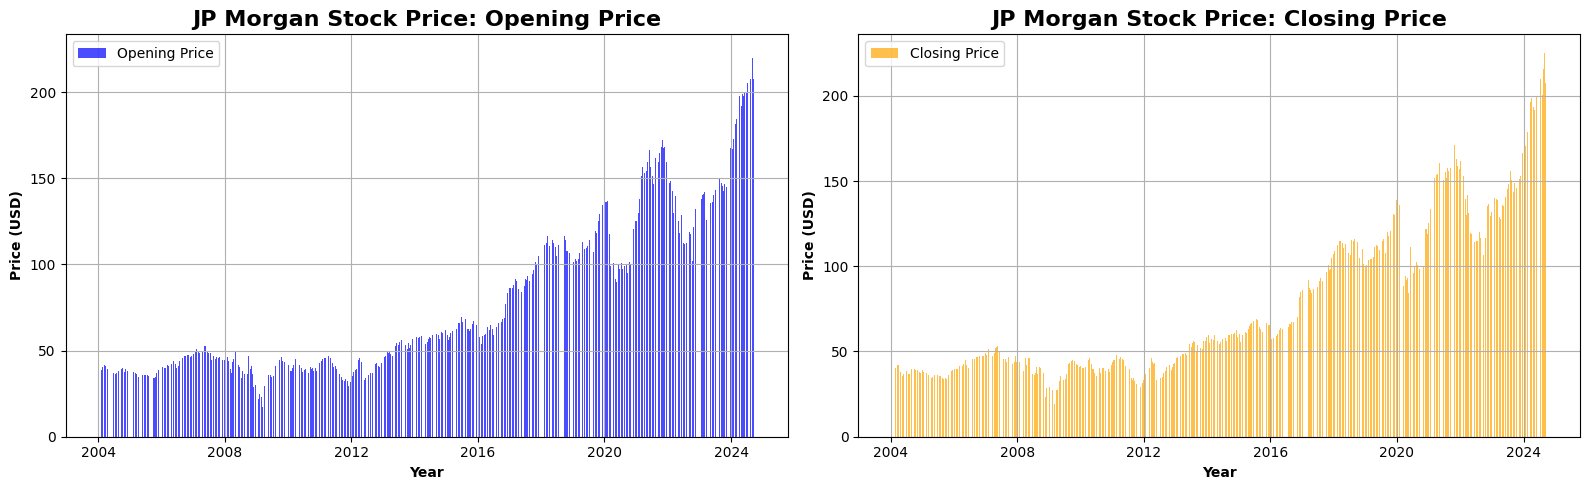

In [6]:
# Creating subplots for Opening and Closing prices
fig, jp = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

# Plot for Opening Price
jp[0].bar(data.index, data['Open'], label='Opening Price', color='blue', linestyle='-', alpha=0.7)
jp[0].set_title("JP Morgan Stock Price: Opening Price", fontsize=16, fontweight='bold')
jp[0].set_xlabel("Year", fontweight='bold')
jp[0].set_ylabel("Price (USD)", fontweight='bold')
jp[0].legend()
jp[0].grid(True)

# Plot for Closing Price
jp[1].bar(data.index, data['Close'], label='Closing Price', color='orange', linestyle='-', alpha=0.7)
jp[1].set_title("JP Morgan Stock Price: Closing Price", fontsize=16, fontweight='bold')
jp[1].set_xlabel("Year", fontweight='bold')
jp[1].set_ylabel("Price (USD)", fontweight='bold')
jp[1].legend()
jp[1].grid(True)

plt.tight_layout()
plt.show()

The plot of JP Morgan's stock prices from 2004 to 2024 reveals a general upward trajectory, with notable dips during the 2008 Great Recession and the 2020 COVID-19 pandemic, both of which significantly impacted stock performance. Despite these downturns, the stock showed resilience, with strong recovery phases evident post-2009 and post-2020. The closing prices closely track the opening prices, suggesting relative intraday stability, with only minor differences between them on most days. Peaks in the stock price are observed in recent years, particularly around 2023-2024, indicating strong performance and investor confidence. Overall, the stock's trend highlights JP Morgan's capacity to recover and grow even after significant economic challenges.

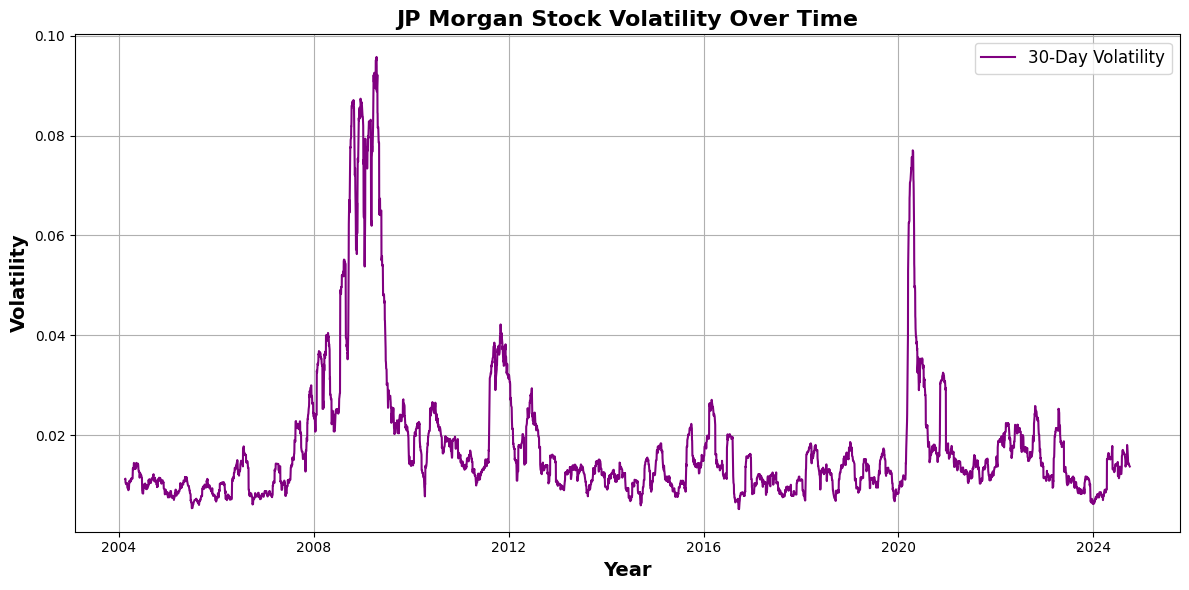

In [7]:
#plot the volatility over time
plt.figure(figsize=(12, 6))
data['Daily_Returns'] = data['Close'].pct_change()
data['Volatility'] = data['Daily_Returns'].rolling(window=30).std()
plt.plot(data.index, data['Volatility'], label='30-Day Volatility', color='purple', alpha=1)
plt.title("JP Morgan Stock Volatility Over Time", fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Volatility', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Volatility as measured by the 30-day rolling standard deviation of daily returns, provides an important perspective on the risk and uncertainity associated with JP Morgan's stock performance over the years. The graph clearly highlights several significant periods like 2008 Financial Crisis, Post 2012 market stabiulization and COVID-19 Pandemic 2020.

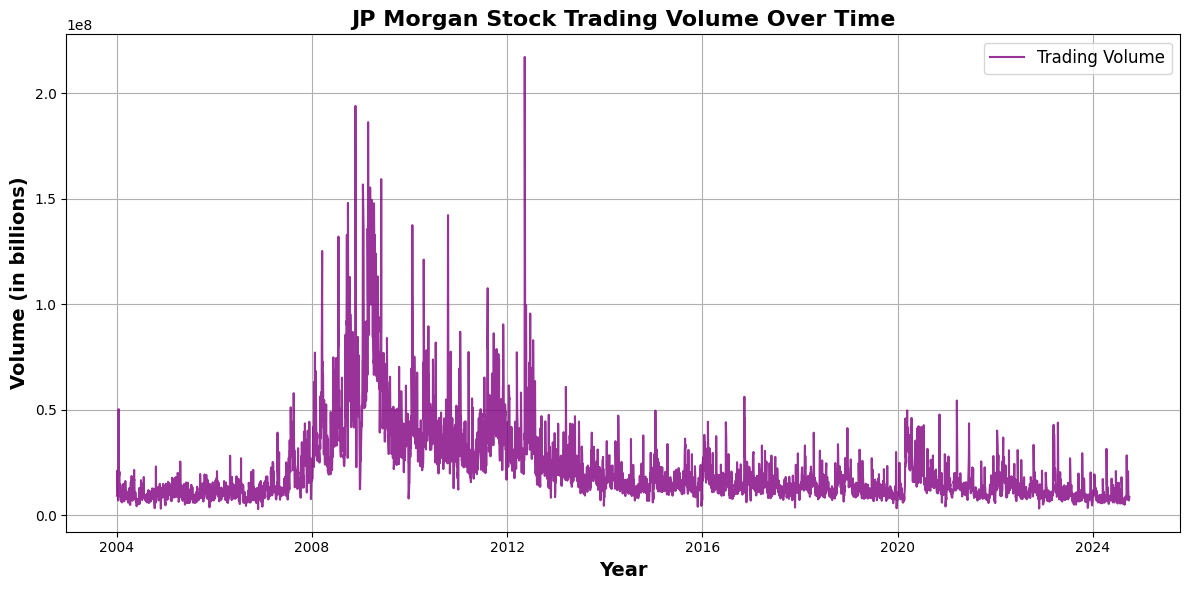

In [8]:
# Plotting Trading Volume Trends over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Volume'], label='Trading Volume', color='purple', alpha=0.8)
plt.title("JP Morgan Stock Trading Volume Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Volume (in billions)", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


The trading volume peaked significantly around 2008-2010, which aligns with the Great Recession period. This suggests increased trading activity during periods of economic uncertainty, likely driven by high volatility and investor reactions.


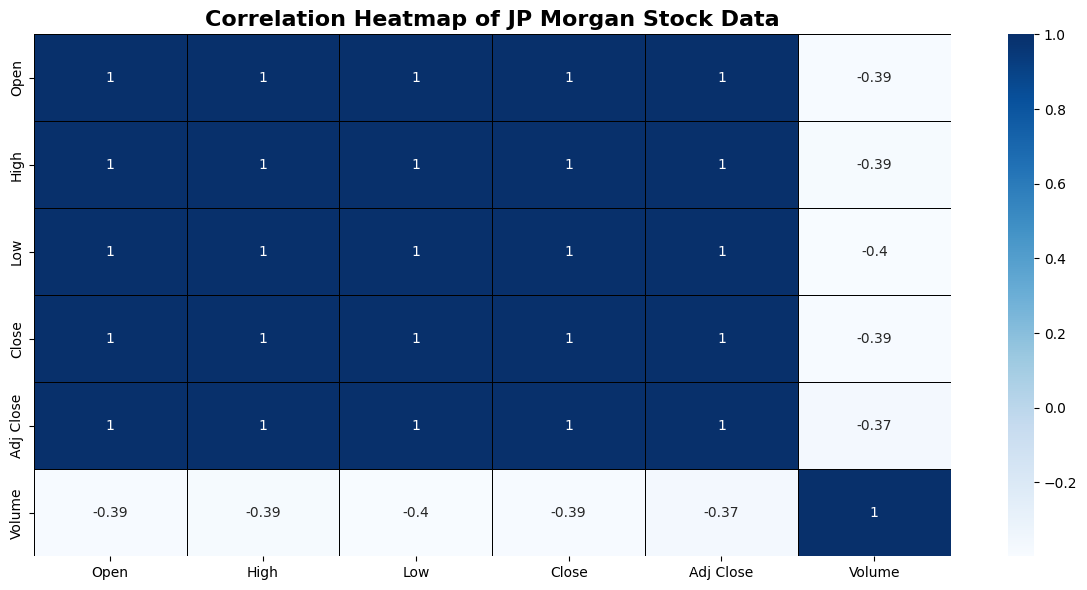

In [9]:
# Correlation Analysis between different numerical features
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Plotting a Heatmap for Correlation
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Correlation Heatmap of JP Morgan Stock Data", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- The heatmap shows very strong correlations between Open, High, Low, Close, and Adj Close prices (correlation = 1), indicating that these features move together closely.

- The Volume has a moderate negative correlation (around -0.39 to -0.40) with price features, implying that high trading volumes may often be associated with lower prices, possibly reflecting heightened selling pressure.


In [10]:
import warnings

warnings.filterwarnings('ignore')

# **Model Selection**

In [11]:
# Data Preparation for Model Training

# Select the features for the models
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Splitting data into train, validation, and test sets
train_data, temp_data, train_target, temp_target = train_test_split(features, target, test_size=0.3, shuffle=False)
val_data, test_data, val_target, test_target = train_test_split(temp_data, temp_target, test_size=0.5, shuffle=False)

# Scaling features using MinMaxScaler for better convergence
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Displaying the shape of the datasets to confirm the splits
(train_data_scaled.shape, val_data_scaled.shape, test_data_scaled.shape)


((3654, 4), (783, 4), (784, 4))

The data has been successfully split and scaled:

**Training Set:** 3,654 observations (70%)

**Validation Set:** 783 observations (15%)

**Test Set:** 784 observations (15%)


#ARIMA Model

In [12]:
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00


In [13]:
# Use the 'Close' column for ARIMA
close_prices = data['Close']
exog = features

forecast_scaler = MinMaxScaler()
forecast_scaler.fit(train_target.values.reshape(-1,1))

# Find the optimal parameters using auto_arima
auto_arima_model = auto_arima(close_prices, exog= exog, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
optimal_order = auto_arima_model.order
print(f"Optimal ARIMA Order: {optimal_order}")


# Fit the ARIMA model
arima_model = ARIMA(close_prices, order=optimal_order, exog= exog)
arima_fit = arima_model.fit()

# Forecast on test set
test_forecast = arima_fit.forecast(steps=len(test_target), exog = test_data)
test_forecast_inversed = forecast_scaler.inverse_transform(test_forecast.values.reshape(-1, 1))

# Evaluate model
test_actual = forecast_scaler.inverse_transform(test_forecast.values.reshape(-1,1))
mae = mean_absolute_error(test_target, test_forecast)
rmse = np.sqrt(mean_squared_error(test_target, test_forecast))

# Calculate metrics on training data
mae = mean_absolute_error(train_target, arima_fit.predict(start=0, end=train_target.index[-1]))
rmse = np.sqrt(mean_squared_error(train_target, arima_fit.predict(start=0, end=train_target.index[-1])))
r2 = r2_score(train_target, arima_fit.predict(start=0, end=train_target.index[-1]))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18923.746, Time=21.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18999.174, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18978.889, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18980.735, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18999.784, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18971.818, Time=8.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18972.723, Time=5.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18971.524, Time=5.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18923.643, Time=10.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18952.420, Time=6.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18925.222, Time=17.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=18925.581, Time=16.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=18937.616, Time=13.95 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=18924.400, Time=16.67 sec
 ARIMA(2,1,3)

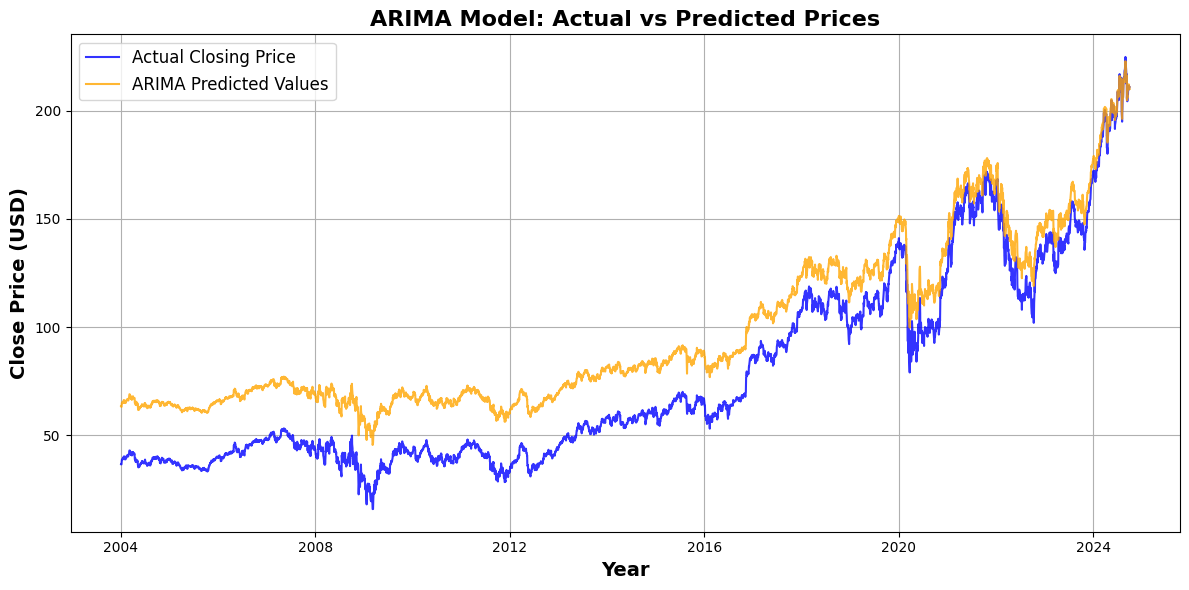

In [14]:
# Generate predictions on the test data
test_forecast = arima_fit.forecast(steps=len(target), exog=features)
# Plotting the Actual vs Predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, target, label='Actual Closing Price', color='blue', alpha=0.8)
plt.plot(data.index, test_forecast, label='ARIMA Predicted Values', color='orange',  alpha=0.8)
plt.title("ARIMA Model: Actual vs Predicted Prices", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Close Price (USD)", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Future Predictions for the next 24 months
future_months = 24
future_forecast = arima_fit.forecast(steps=future_months, exog=features[-future_months:])

# Generate future dates
future_dates = pd.date_range(start=data.index[-1], periods=future_months + 1, freq='ME')[1:]

future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_forecast})
future_predictions_df.set_index('Date', inplace=True)

#print the predictions
print("Future Predictions for the next 24 Months:")
print(future_predictions_df)


Future Predictions for the next 24 Months:
            Predicted_Close
Date                       
2024-10-31       218.846379
2024-11-30       220.432665
2024-12-31       219.028425
2025-01-31       222.790014
2025-02-28       220.011359
2025-03-31       217.753477
2025-04-30       216.546012
2025-05-31       213.009144
2025-06-30       216.274621
2025-07-31       204.810736
2025-08-31       205.720309
2025-09-30       207.259414
2025-10-31       205.699725
2025-11-30       208.451984
2025-12-31       210.054848
2026-01-31       209.623377
2026-02-28       210.042703
2026-03-31       211.145141
2026-04-30       211.110280
2026-05-31       212.148447
2026-06-30       210.027460
2026-07-31       210.251463
2026-08-31       211.326757
2026-09-30       209.969225


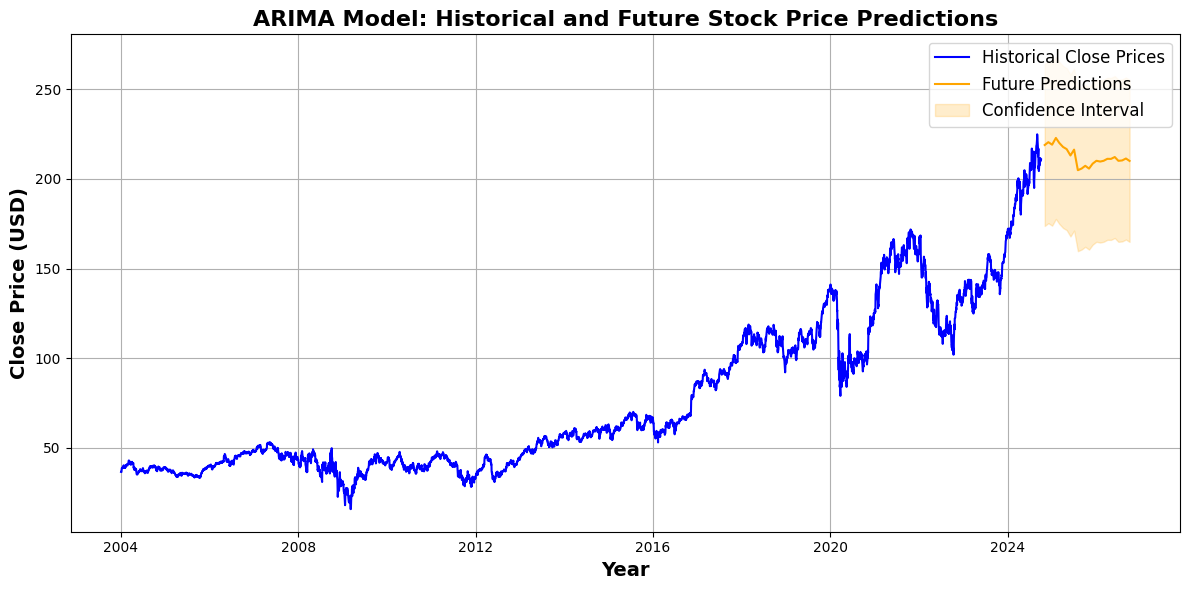

In [16]:
std_dev = np.std(close_prices)
lower_bound = future_predictions_df['Predicted_Close'] - std_dev
upper_bound = future_predictions_df['Predicted_Close'] + std_dev

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, close_prices, label='Historical Close Prices', color='blue')
plt.plot(future_predictions_df.index, future_predictions_df['Predicted_Close'], label='Future Predictions', color='orange')
plt.fill_between(future_predictions_df.index, lower_bound, upper_bound, color='orange', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Model: Historical and Future Stock Price Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Close Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM Model


In [17]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Preparing Data for LSTM Model
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the close price using MinMaxScaler
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler_close.fit_transform(close_prices)

# Create sequences from residuals for LSTM input
def create_sequences(data, time_steps):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i:i + time_steps])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

# Define the number of time steps (look-back period) for LSTM
time_steps = 30

X, y = create_sequences(scaled_prices, time_steps)

# Split into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Build the LSTM Model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#To prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate on test data
y_pred_scaled = model.predict(X_test)
y_pred = scaler_close.inverse_transform(y_pred_scaled)
y_actual = scaler_close.inverse_transform(y_test)

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0121 - val_loss: 0.0020
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - loss: 2.5336e-04 - val_loss: 8.3564e-04
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 2.4610e-04 - val_loss: 9.1728e-04
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.2915e-04 - val_loss: 6.8406e-04
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.9132e-04 - val_loss: 6.4428e-04
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 1.7866e-04 - val_loss: 6.0868e-04
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.8648e-04 - val_loss: 5.6283e-04
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 1.6827e-04 - val_loss: 5.7658e-04
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.6814e-04 - val_loss: 4.6686e-04
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 1.3279e-04 - val_loss: 4.8286e-04
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


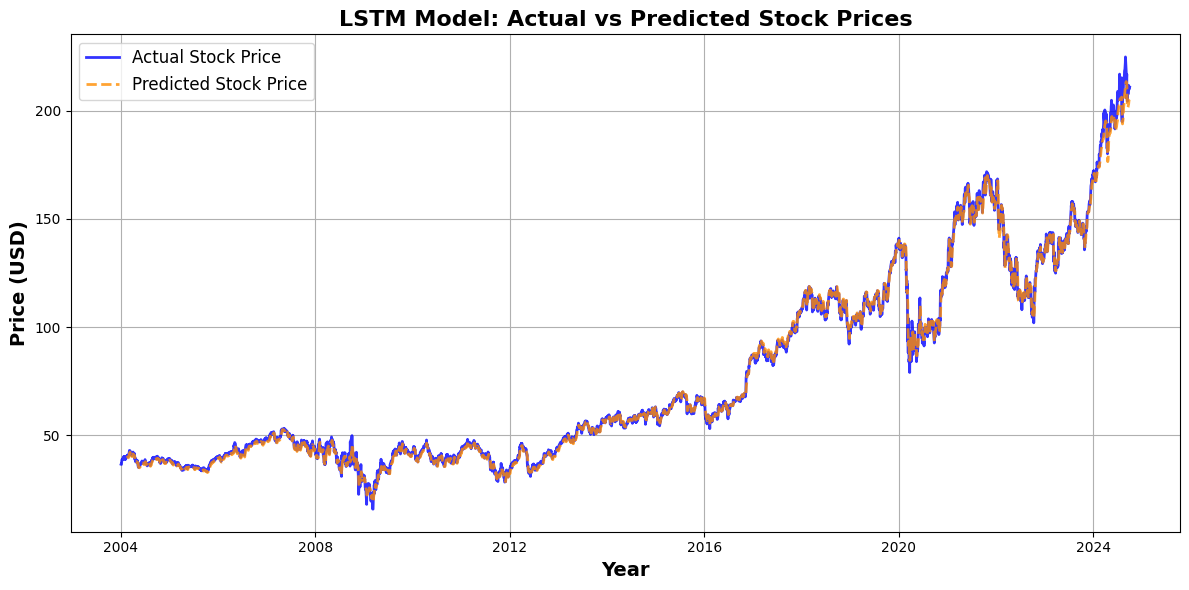

In [18]:
std_dev = np.std(y_pred- y_actual)

X_full = []
for i in range(time_steps, len(scaled_prices)):
    sequence = scaled_prices[i - time_steps:i]
    X_full.append(sequence)

X_full = np.array(X_full)
full_predictions = model.predict(X_full, batch_size=32)
full_predictions_unscaled = scaler_close.inverse_transform(full_predictions)
all_predictions = pd.Series(full_predictions_unscaled.flatten(), index=data.index[time_steps:])

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, close_prices, label='Actual Stock Price', color='blue', linewidth=2, alpha=0.8)
plt.plot(all_predictions.index, all_predictions, label='Predicted Stock Price', color='darkorange', linestyle='--', linewidth=2, alpha=0.8)
plt.title('LSTM Model: Actual vs Predicted Stock Prices', fontweight='bold', fontsize=16)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Future Predictions for the next 24 months
future_months = 24

if len(X_test) > 0 and X_test.shape[0] > 0 and X_test.ndim == 3:
  last_sequence = X_test[-1]
else:
  print("Using Historical Data to create the last sequence")
  last_sequence = scaled_prices[-time_steps:]

future_predictions = []
for _ in range(future_months):
    next_prediction = model.predict(last_sequence.reshape(1, time_steps, 1))
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

# Inverse transform future predictions to original scale
future_predictions_unscaled = scaler_close.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_months + 1, freq='ME')[1:]

future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions_unscaled.flatten()})
future_df.set_index('Date', inplace=True)

# Print future predictions
print("Future Predictions for the next 24 months:")
print(future_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Future Predictions for the next 24 months:
            Predicted_Close
Date             

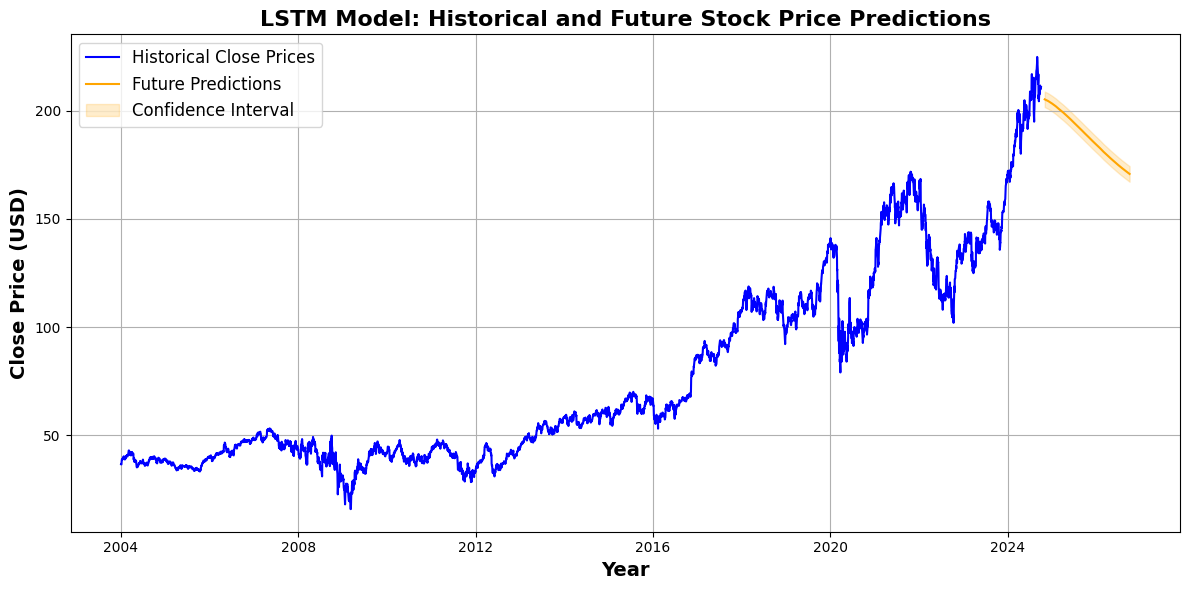

In [20]:
lower_bound = future_df['Predicted_Close'] - std_dev
upper_bound = future_df['Predicted_Close'] + std_dev

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Prices', color='blue')
plt.plot(future_df.index, future_df['Predicted_Close'], label='Future Predictions', color='orange')
plt.fill_between(future_df.index, lower_bound, upper_bound, color='orange', alpha=0.2, label='Confidence Interval')
plt.title('LSTM Model: Historical and Future Stock Price Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Close Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost Model

In [21]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor


In [22]:
SEED = 42
np.random.seed(SEED)

close_prices = data['Close'].values
data_index = data.index

# Selecting features for XGBoost
data_xgb = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].copy()
features = data_xgb[['Open', 'High', 'Low', 'Volume']]
target = data_xgb['Close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=SEED)

# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=6, learning_rate=0.03, random_state=SEED)

# Train the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Calculate Evaluation Metrics for XGBoost model on test data
mae_xgboost = mean_absolute_error(y_test, y_pred)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred))
r2_xgboost = r2_score(y_test, y_pred)

# Print Evaluation Metrics for XGBoost model on test data
print("Evaluation Metrics for XGBoost model on test data:")
print(f"MAE: {mae_xgboost}")
print(f"RMSE: {rmse_xgboost}")
print(f"R-squared: {r2_xgboost}")




Evaluation Metrics for XGBoost model on test data:
MAE: 0.5083266023334705
RMSE: 0.7828255452102302
R-squared: 0.9996893506630126


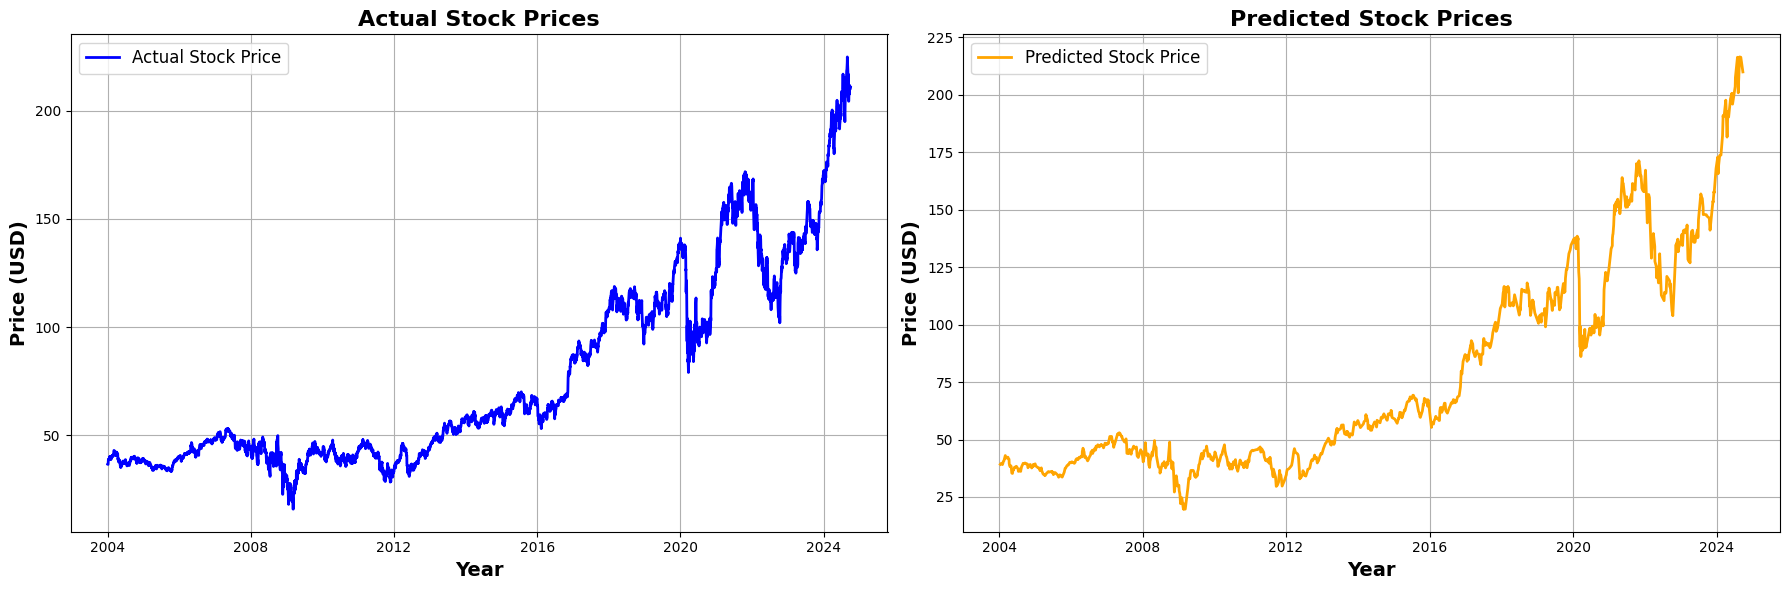

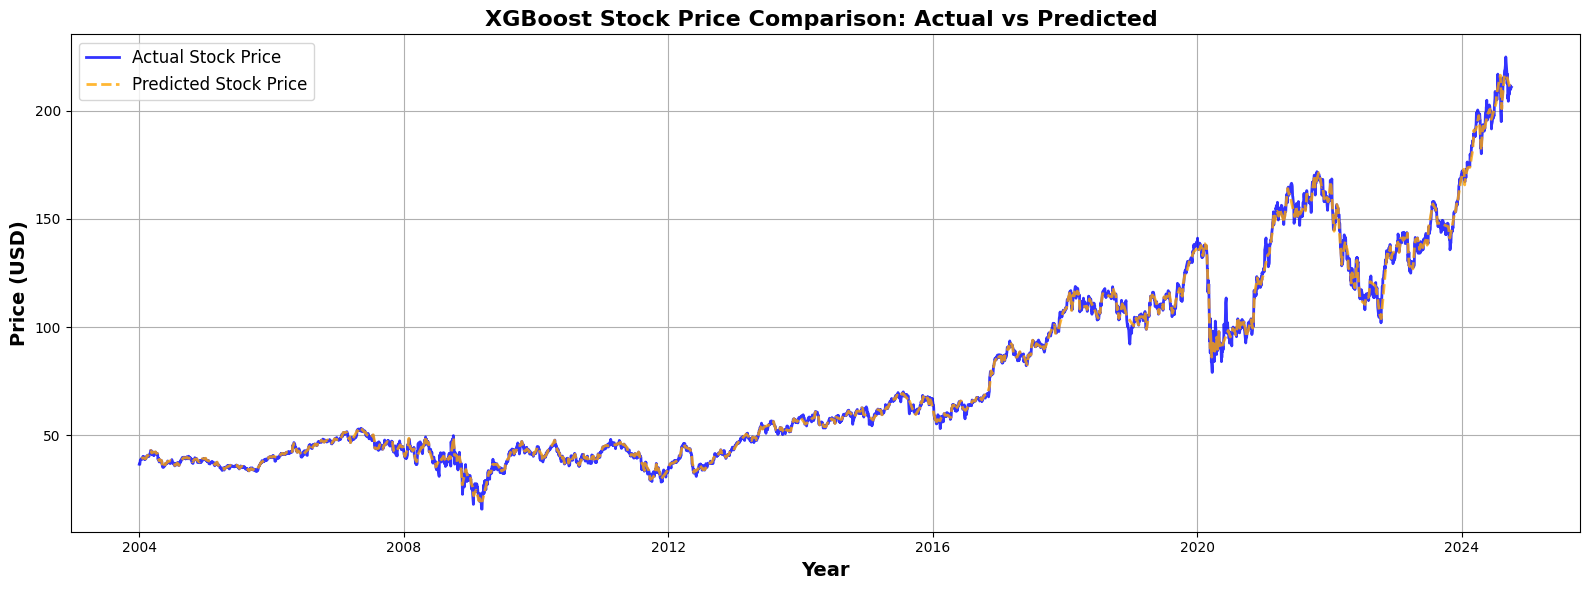

In [23]:
predicted_prices_series = pd.Series(y_pred, index=X_test.index).sort_index()

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#plot for Actual stock prices
axes[0].plot(data.index, data['Close'], label='Actual Stock Price', color='blue', linewidth=2)
axes[0].set_title('Actual Stock Prices', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True)

#plot for Predicted stock prices
axes[1].plot(predicted_prices_series.index, predicted_prices_series, label='Predicted Stock Price', color='orange', linewidth=2)
axes[1].set_title('Predicted Stock Prices', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True)
plt.tight_layout()
plt.show()

# Plotting the actual vs predicted stock prices
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['Close'], label='Actual Stock Price', color='blue', linewidth=2, alpha=0.8)
plt.plot(predicted_prices_series.index, predicted_prices_series, label='Predicted Stock Price', color='orange', linestyle='--', linewidth=2, alpha=0.8)
plt.title('XGBoost Stock Price Comparison: Actual vs Predicted ', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Prepare data for 24 months of future predictions
future_months = 24
last_features = features.iloc[-1].values.reshape(1, -1)
future_predictions = []

for _ in range(future_months):
    next_prediction = xgboost_model.predict(last_features)
    future_predictions.append(next_prediction[0])

# Adjust features based on past trends
    new_features = last_features[0]
    new_features[0] = new_features[0] * 1.005
    new_features[1] = max(new_features[0], new_features[1] * 1.004)
    new_features[2] = min(new_features[0], new_features[2] * 0.996)
    new_features[3] = new_features[3] * 0.99

    last_features = np.array(new_features).reshape(1, -1)

# Convert future predictions to a DataFrame
future_dates = pd.date_range(start=data.index[-1], periods=future_months + 1, freq='ME')[1:]

future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions})
future_predictions_df.set_index('Date', inplace=True)

# Print future predictions
print("Future Predictions for the next 24 months:")
print(future_predictions_df)


Future Predictions for the next 24 months:
            Predicted_Close
Date                       
2024-10-31       207.719788
2024-11-30       209.271973
2024-12-31       209.271973
2025-01-31       209.271973
2025-02-28       207.731384
2025-03-31       207.637512
2025-04-30       207.637512
2025-05-31       206.380920
2025-06-30       206.380920
2025-07-31       203.950027
2025-08-31       203.926987
2025-09-30       203.693573
2025-10-31       203.964005
2025-11-30       202.767593
2025-12-31       202.767593
2026-01-31       202.767593
2026-02-28       203.374512
2026-03-31       203.374512
2026-04-30       200.802338
2026-05-31       200.802338
2026-06-30       200.802338
2026-07-31       200.802338
2026-08-31       200.720963
2026-09-30       200.720963


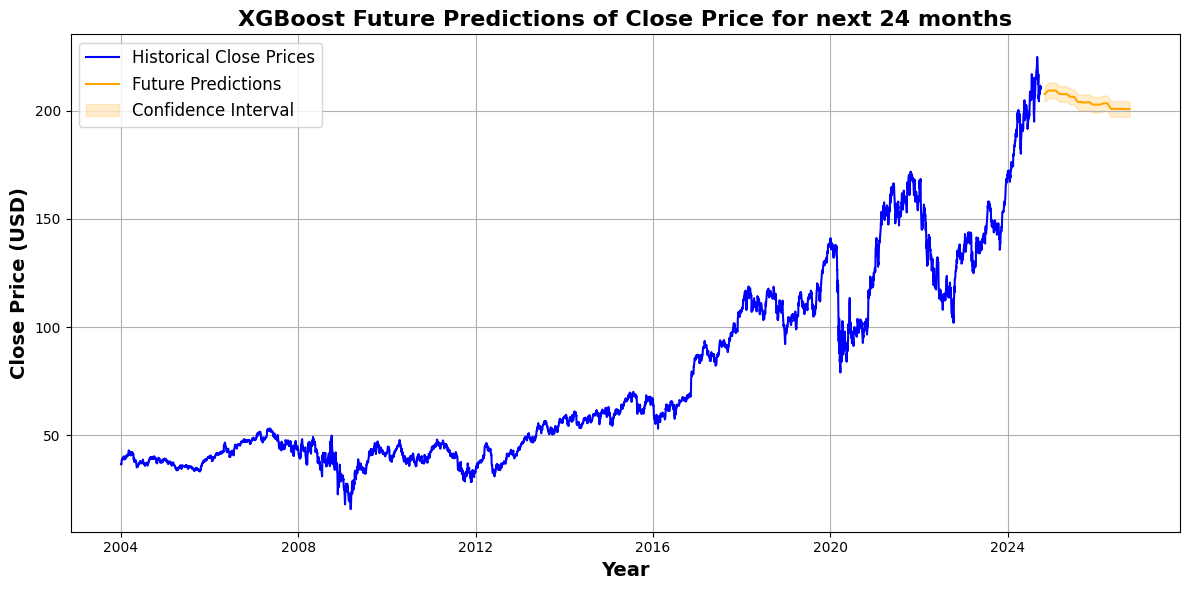

In [25]:
lower_bound = future_predictions_df['Predicted_Close'] - std_dev
upper_bound = future_predictions_df['Predicted_Close'] + std_dev

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Prices', color='blue')
plt.plot(future_predictions_df.index, future_predictions_df['Predicted_Close'], label='Future Predictions', color='orange')
plt.fill_between(future_predictions_df.index, lower_bound, upper_bound, color='orange', alpha=0.2, label='Confidence Interval')
plt.title('XGBoost Future Predictions of Close Price for next 24 months', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Close Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# **HYBRID MODEL (ARIMA+LSTM)**

In [26]:
SEED = 42
np.random.seed(SEED)

train_size = int(len(data) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]
test_index = data_index[train_size:]

from pmdarima import auto_arima

auto_arima_order = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True, error_action='ignore', max_order=5)
optimal_order = auto_arima_order.order
print(f"Optimal ARIMA Order: {optimal_order}")

arima_model = ARIMA(train, order=optimal_order)
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13512.988, Time=15.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13666.129, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13585.231, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13593.149, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13664.668, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13579.093, Time=5.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13580.628, Time=8.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13514.596, Time=11.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13514.590, Time=6.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13580.879, Time=1.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13554.817, Time=4.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13578.090, Time=6.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13514.947, Time=12.95 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13511.638, Time=2.38 sec
 ARIMA(1,1,2)(0,

In [27]:
# Generate ARIMA predictions
arima_residuals = test - arima_forecast

scaler = MinMaxScaler(feature_range=(0, 1))
residuals_scaled = scaler.fit_transform(arima_residuals.reshape(-1, 1))

In [28]:
# Helper function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train_lstm, y_train_lstm = create_sequences(residuals_scaled, seq_length)

In [29]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


In [30]:
# Train LSTM model with Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0937
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0037
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0037
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0030
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0033
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0027
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0030
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0027
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025
Epoc

In [31]:
test_residuals_scaled = scaler.transform(arima_residuals.reshape(-1, 1))
X_test_lstm, _ = create_sequences(test_residuals_scaled, seq_length)
lstm_forecast = lstm_model.predict(X_test_lstm)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [32]:
# Predict residuals using LSTM
lstm_forecast_unscaled = scaler.inverse_transform(lstm_forecast)
hybrid_forecast = arima_forecast[seq_length:] + lstm_forecast_unscaled.ravel()

In [33]:
mae = mean_absolute_error(test[seq_length:], hybrid_forecast)
rmse = np.sqrt(mean_squared_error(test[seq_length:], hybrid_forecast))
r2 = r2_score(test[seq_length:], hybrid_forecast)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 2.726891040771989
RMSE: 3.5331890978536675
R² Score: 0.9840800695907497


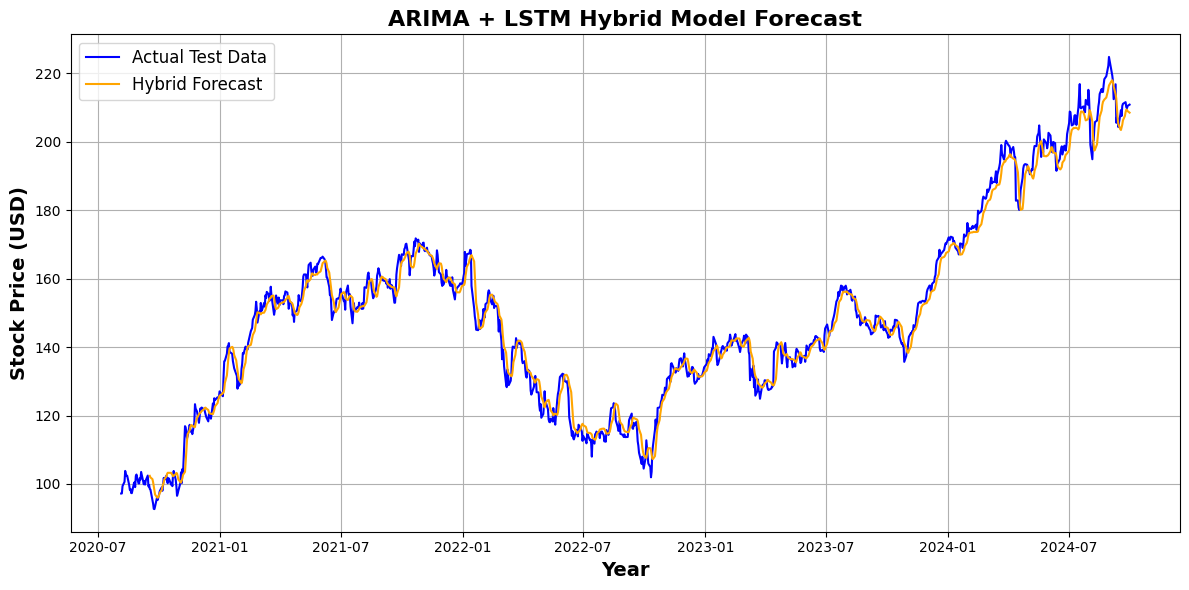

In [34]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_index, test, label='Actual Test Data', color='blue')
plt.plot(test_index[seq_length:], hybrid_forecast, label='Hybrid Forecast', color='orange')
plt.title('ARIMA + LSTM Hybrid Model Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Future Predictions
future_months = 24

last_date = data.index[-1]

arima_future_forecast = arima_model_fit.forecast(steps=future_months)

# Initialize LSTM future predictions with last sequence from test residuals
last_sequence = test_residuals_scaled[-seq_length:]
future_residuals = []

for _ in range(future_months):
    next_residual = lstm_model.predict(last_sequence.reshape(1, seq_length, 1))
    random_adjustment = np.random.normal(0, 0.05, size=1)
    next_residual_adjustment = next_residual[0,0] + random_adjustment[0]
    future_residuals.append(next_residual_adjustment)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_residual_adjustment

# Inverse transform LSTM residuals
future_residuals_unscaled = scaler.inverse_transform(np.array(future_residuals).reshape(-1, 1)).ravel()

# Combine ARIMA and LSTM predictions for the future
future_hybrid_forecast = arima_future_forecast + future_residuals_unscaled

# Create future dates
#last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_months + 1, freq='ME')[1:]

# Create DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_hybrid_forecast
})
future_predictions_df.set_index('Date', inplace=True)

# Print future predictions
print("Future Predictions for the next 24 months:")
print(future_predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Future Predictions for the next 24 months:
            Predicted_Close
Date             

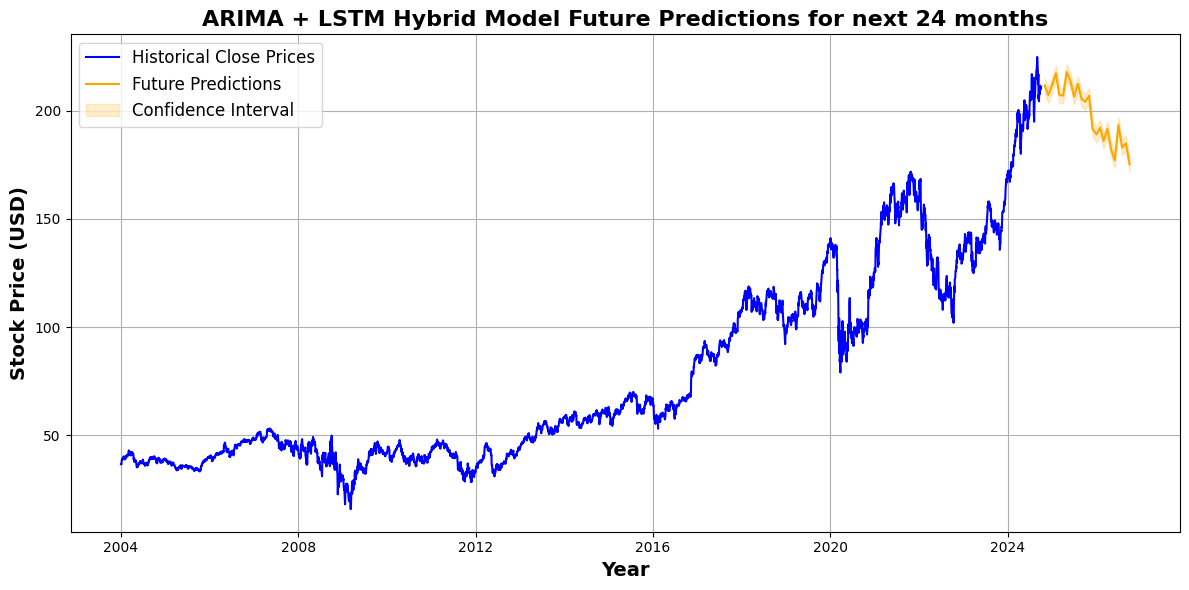

In [36]:
lower_bound = future_predictions_df['Predicted_Close'] - std_dev
upper_bound = future_predictions_df['Predicted_Close'] + std_dev

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Prices', color='blue')
plt.plot(future_predictions_df.index, future_hybrid_forecast, label='Future Predictions', color='orange')
plt.fill_between(future_predictions_df.index, lower_bound, upper_bound, color='orange', alpha=0.2,  label='Confidence Interval')
plt.title('ARIMA + LSTM Hybrid Model Future Predictions for next 24 months', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# **COVID & GREAT RECESSION Impacts on JPMorgan's stock prices**

In [37]:
!pip install plotly
import plotly.graph_objects as go

In [38]:
#Creating New DataFrame with closing prices and corresponding dates
data_df = pd.DataFrame({'Date': data.index, 'Close': data['Close'], 'Open': data['Open'],'High': data['High'], 'Low': data['Low'], 'Volume': data['Volume']})

#Setting 'Date' as the index of the DataFrame
data_df.set_index('Date', inplace=True)

# Filtering data for the Great Recession and COVID-19 pandemic
recession_data = data_df.loc['2007-12-01':'2009-06-30']
covid_data = data_df.loc['2020-03-01':'2020-12-31']

In [39]:
# Function to create a candlestick chart
def create_candlestick_chart(df, title):
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close']
    )])
    fig.update_layout(title=title,
                      xaxis_title="Date",
                      yaxis_title="Price (USD)",
                      xaxis_rangeslider_visible=False)
    fig.show()

# Create candlestick chart for Great Recession
create_candlestick_chart(recession_data, "JP Morgan Stock Price During the Great Recession (2007-2009)")

# Create candlestick chart for COVID-19 Pandemic
create_candlestick_chart(covid_data, "JP Morgan Stock Price During the COVID-19 Pandemic (2020)")


**Great Recession (2007-2009):**
JP Morgan's stock prices showed big drops and slight recoveries, with large fluctuations over time.
The downward trend lasted a long time, showing the slow recovery during the financial crisis.

**COVID-19 Pandemic (2020):**
During the COVID-19 pandemic, the stock price fell sharply in March 2020 but recovered quickly by the end of 2020.
The smaller fluctuations later in the year show the market stabilizing faster than during the Great Recession.

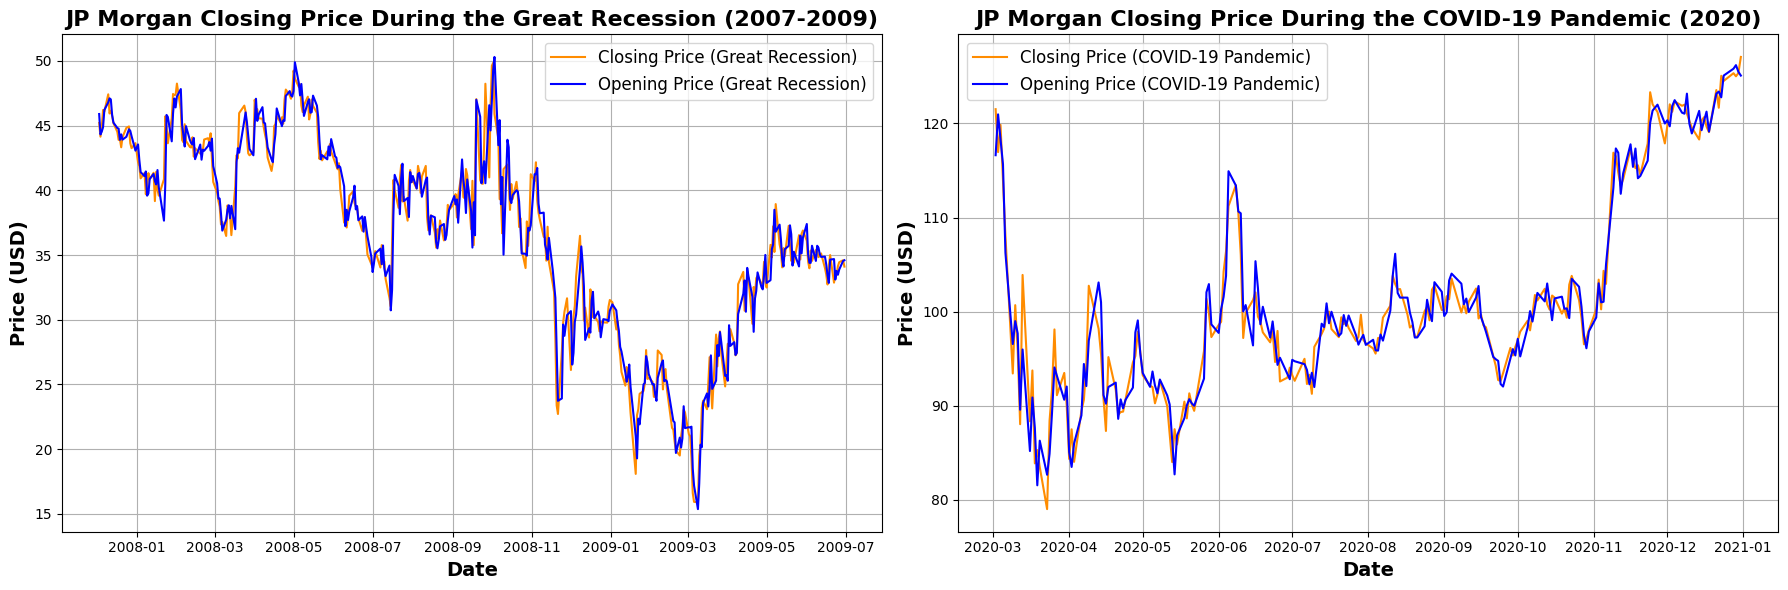

In [40]:
# Plotting the Opening & Closing Price during the Great Recession
fig, axes = plt.subplots(1,2, figsize=(18,6), sharey=False)

# Plot for the Great Recession
axes[0].plot(recession_data.index, recession_data['Close'], label='Closing Price (Great Recession)', color='darkorange')
axes[0].plot(recession_data.index, recession_data['Open'], label='Opening Price (Great Recession)', color='blue')
axes[0].set_title("JP Morgan Closing Price During the Great Recession (2007-2009)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Price (USD)", fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True)


# Plotting the Opening & Closing Price during the COVID-19 Pandemic
axes[1].plot(covid_data.index, covid_data['Close'], label='Closing Price (COVID-19 Pandemic)', color='darkorange')
axes[1].plot(covid_data.index, covid_data['Open'], label='Opening Price (COVID-19 Pandemic)', color='blue')
axes[1].set_title("JP Morgan Closing Price During the COVID-19 Pandemic (2020)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Price (USD)", fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True)
plt.tight_layout()
plt.show()

**Great Recession (2007-2009):** The Closing price fell significantly and showed high volatility, with frequent ups and downs. The stock experienced a steep decline during late 2008, reflecting market turmoil.

**COVID-19 Pandemic (2020):** Similarly, during the initial months of the COVID-19 pandemic, there was a sharp decline in the stock price, followed by a period of recovery towards the end of 2020. This reflects the market's initial negative reaction to the pandemic and subsequent stabilization as conditions improved.

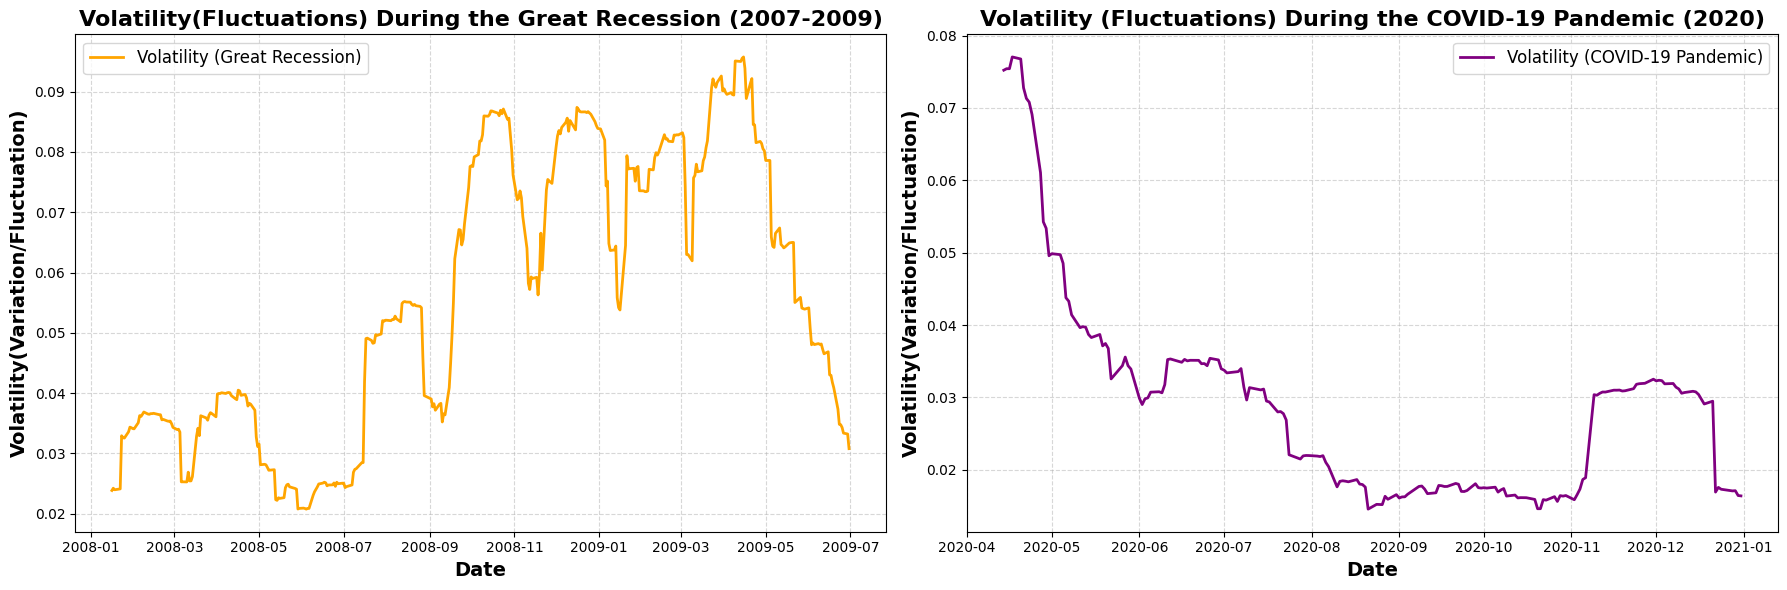

In [41]:
recession_data = data_df.loc['2007-12-01':'2009-06-30'].copy()
covid_data = data_df.loc['2020-03-01':'2020-12-31'].copy()

# Calculate daily returns and rolling volatility for Great Recession
recession_data['Daily Returns'] = recession_data['Close'].pct_change()
recession_data['Volatility'] = recession_data['Daily Returns'].rolling(window=30).std()

# Calculate daily returns and rolling volatility for COVID-19 Pandemic
covid_data['Daily Returns'] = covid_data['Close'].pct_change()
covid_data['Volatility'] = covid_data['Daily Returns'].rolling(window=30).std()

fig, axes = plt.subplots(1,2, figsize=(18,6), sharey=False)

# Plot for the Great Recession
axes[0].plot(recession_data.index, recession_data['Volatility'], label='Volatility (Great Recession)', color='orange', linewidth=2)
axes[0].set_title("Volatility(Fluctuations) During the Great Recession (2007-2009)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Volatility(Variation/Fluctuation)", fontsize=14, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(fontsize=12)

# Plot for the COVID-19 Pandemic
axes[1].plot(covid_data.index, covid_data['Volatility'], label='Volatility (COVID-19 Pandemic)', color='purple', linewidth=2)
axes[1].set_title("Volatility (Fluctuations) During the COVID-19 Pandemic (2020)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Volatility(Variation/Fluctuation)", fontsize=14, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


**The Great Recessio**n saw a gradual rise in volatility, peaking in late 2008, with elevated levels persisting for a prolonged period due to systemic financial instability.
**The COVID-19 pandemic** caused a sharp volatility spike in March 2020, followed by a rapid decline as markets stabilized.
**The Great Recession** reflects sustained uncertainty, while **the COVID-19 pandemic** represents a short-term shock with quicker recovery. This comparison highlights the differences in market responses to these two major crises.

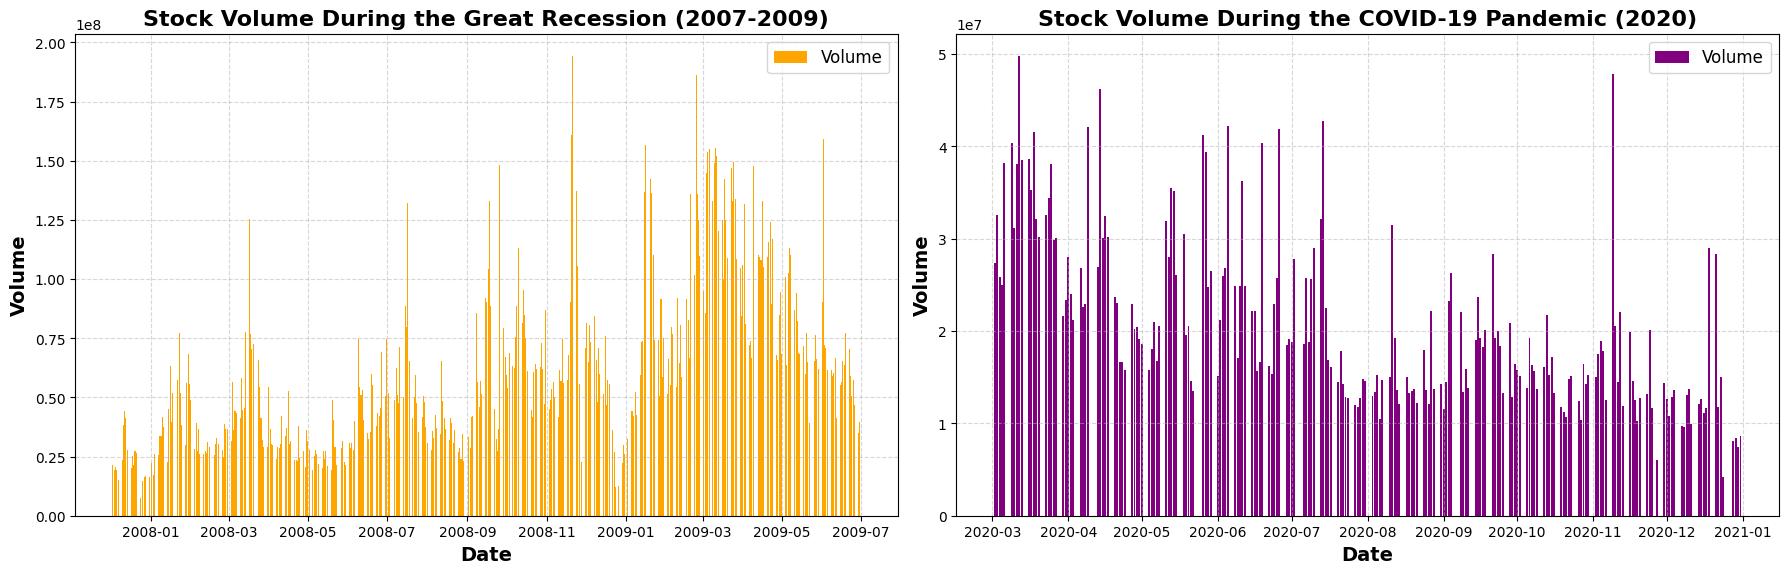

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Volume during the Great Recession
axes[0].bar(recession_data.index, recession_data['Volume'], color='orange', label='Volume')
axes[0].set_title("Stock Volume During the Great Recession (2007-2009)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Volume", fontsize=14, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(fontsize=12)

# Volume during the COVID-19 Pandemic
axes[1].bar(covid_data.index, covid_data['Volume'], color='purple', label='Volume')
axes[1].set_title("Stock Volume During the COVID-19 Pandemic (2020)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Volume", fontsize=14, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


**Great Recession**
Trading volume stayed high for a long time during the Great Recession, showing that investors were very uncertain and cautious.
The market adjusted slowly as the crisis continued.

**COVID-19 Pandemic**
During the COVID-19 Pandemic, trading volume spiked sharply at the start but returned to normal much faster than during the Great Recession.
This shows that the market adapted quickly to the crisis.

Great Recession Recovery Date: 2007-12-03 00:00:00
COVID-19 Recovery Date: 2020-03-02 00:00:00


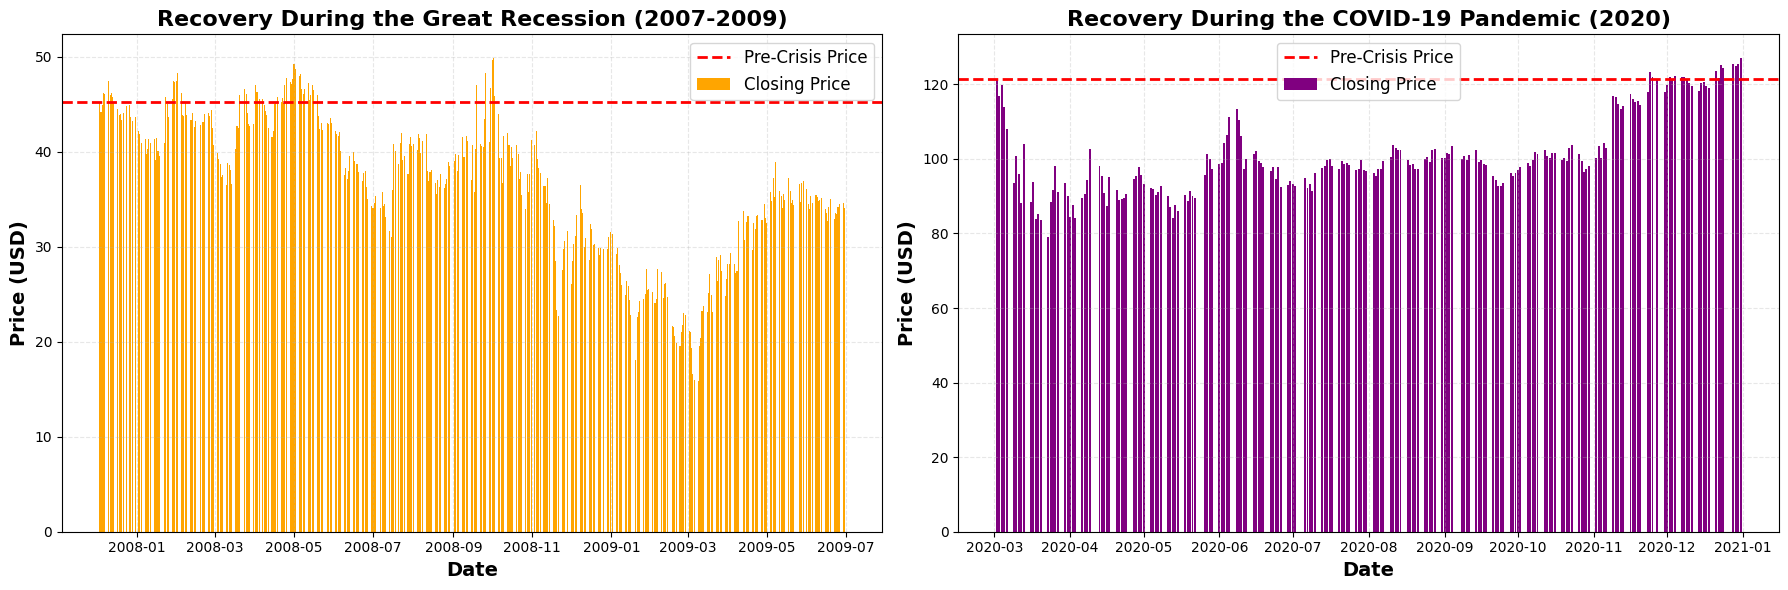

In [43]:
# Function to calculate recovery date
def calculate_recovery_date(df, pre_crisis_close):
    recovery_date = df[df['Close'] >= pre_crisis_close].index.min()
    return recovery_date

# Recovery analysis for Great Recession
pre_crisis_close_recession = recession_data['Close'].iloc[0]
recovery_date_recession = calculate_recovery_date(recession_data, pre_crisis_close_recession)
print(f"Great Recession Recovery Date: {recovery_date_recession}")

# Recovery analysis for COVID-19 Pandemic
pre_crisis_close_covid = covid_data['Close'].iloc[0]
recovery_date_covid = calculate_recovery_date(covid_data, pre_crisis_close_covid)
print(f"COVID-19 Recovery Date: {recovery_date_covid}")

fig, axes = plt.subplots(1,2, figsize=(18,6), sharey=False)
# Line plot to visualize recovery for Great Recession
axes[0].bar(recession_data.index, recession_data['Close'], label='Closing Price', color='orange')
axes[0].axhline(pre_crisis_close_recession, color='red', linestyle='--', linewidth=2, label='Pre-Crisis Price')
axes[0].set_title("Recovery During the Great Recession (2007-2009)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Price (USD)", fontsize=14, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].legend(fontsize=12)

# Line plot to visualize recovery for COVID-19 Pandemic
axes[1].bar(covid_data.index, covid_data['Close'], label='Closing Price', color='purple')
axes[1].axhline(pre_crisis_close_covid, color='red', linestyle='--', linewidth=2, label='Pre-Crisis Price')
axes[1].set_title("Recovery During the COVID-19 Pandemic (2020)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Price (USD)", fontsize=14, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].legend(fontsize=12)
plt.tight_layout()
plt.show()



**Recovery During the Great Recession (2007-2009)**
JP Morgan's stock price dropped significantly and took a long time to recover to its pre-crisis level, The price showed large fluctuations over time, reflecting ongoing market instability.

**Recovery During the COVID-19 Pandemic (2020)**
During the COVID-19 pandemic, the stock price dropped sharply but recovered much faster compared to the Great Recession. By the end of 2020, the price had returned to its pre-crisis level, showing a quicker recovery phase.